### **Mô tả Dataset**
*  Bộ dữ liệu **WeatherAUS** là tập dữ liệu dự báo thời tiết được thu thập bởi Cơ quan Khí tượng Úc (Australian Bureau of Meteorology).  
Dataset chứa thông tin thời tiết của nhiều trạm khí tượng trên khắp nước Úc trong giai đoạn **2007–2017**.

* Mục tiêu chính của bài toán là **dự đoán khả năng có mưa vào ngày mai** (`RainTomorrow`), một bài toán thuộc loại **phân loại nhị phân**.

---

### **Thông tin chung về dataset**
* **Số dòng dữ liệu:** ~145,000  
* **Số cột:** 23  
* **Dạng bài toán:** Classification  
* **Biến mục tiêu:** `RainTomorrow` (Yes/No => 1/0 sau khi mã hóa)

---

###  **Các nhóm thuộc tính chính**

#### 1. Thông tin vị trí
* `Location`: Tên trạm khí tượng (Sydney, Canberra, Darwin, …)

#### 2. Thông tin thời gian
* `Date`: Ngày quan sát (yyyy-mm-dd)

#### 3. Các thông số thời tiết ghi nhận
* `MinTemp`: Nhiệt độ thấp nhất trong ngày (°C)
* `MaxTemp`: Nhiệt độ cao nhất trong ngày (°C)
* `Rainfall`: Lượng mưa ghi nhận (mm)
* `Evaporation`: Lượng bốc hơi (mm)
* `Sunshine`: Số giờ nắng
* `WindGustSpeed`: Tốc độ gió giật mạnh nhất (km/h)
* `WindSpeed9am`, `WindSpeed3pm`: Tốc độ gió tại 9h/15h
* `Humidity9am`, `Humidity3pm`: Độ ẩm
* `Pressure9am`, `Pressure3pm`: Áp suất khí quyển
* `Cloud9am`, `Cloud3pm`: Mức độ mây (0–8)
* `Temp9am`, `Temp3pm`: Nhiệt độ tại 9h/15h

#### 4. Các thông tin về mưa
* `RainToday`: (Yes/No)
* `RainTomorrow`: **biến mục tiêu**

---

### **Một số vấn đề về bộ dữ liệu**
* Nhiều giá trị bị thiếu (đặc biệt ở: `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm`).
* Dữ liệu không đồng đều giữa các địa điểm.
* Nhiều biến numeric chứa outliers (Rainfall, WindGustSpeed,…).
* Dữ liệu chưa được chuẩn hóa thang đo.


### 1. Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

### 2. Đọc dữ liệu và xem kích thước

In [ ]:
df = pd.read_csv('/content/weatherAUS.csv')
df.head(), df.shape

(         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
 0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
 1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
 2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
 3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
 4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
 
   WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
 0           W           44.0          W  ...        71.0         22.0   
 1         WNW           44.0        NNW  ...        44.0         25.0   
 2         WSW           46.0          W  ...        38.0         30.0   
 3          NE           24.0         SE  ...        45.0         16.0   
 4           W           41.0        ENE  ...        82.0         33.0   
 
    Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
 0 

In [ ]:
cols = [
    "MinTemp", "MaxTemp", "Rainfall",
    "Evaporation", "Sunshine",
    "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm",
    "Humidity9am", "Humidity3pm",
    "Pressure9am", "Pressure3pm",
    "Cloud9am", "Cloud3pm",
    "Temp9am", "Temp3pm"
]

cols = [c for c in cols if c in df.columns]

summary = pd.DataFrame({
    "Count": df[cols].count(),
    "Mean": df[cols].mean(),
    "Median": df[cols].median(),
    "Std": df[cols].std(),
    "Min": df[cols].min(),
    "Max": df[cols].max()
}).round(2)

summary

,Count,Mean,Median,Std,Min,Max
MinTemp,143975,12.19,12.0,6.40,-8.5,33.9
MaxTemp,144199,23.22,22.6,7.12,-4.8,48.1
Rainfall,142199,2.36,0.0,8.48,0.0,371.0
Evaporation,82670,5.47,4.8,4.19,0.0,145.0
Sunshine,75625,7.61,8.4,3.79,0.0,14.5
WindGustSpeed,135197,40.04,39.0,13.61,6.0,135.0
WindSpeed9am,143693,14.04,13.0,8.92,0.0,130.0
WindSpeed3pm,142398,18.66,19.0,8.81,0.0,87.0
Humidity9am,142806,68.88,70.0,19.03,0.0,100.0
Humidity3pm,140953,51.54,52.0,20.80,0.0,100.0


### 3. Kiểm tra dữ liệu bị thiếu


*   Xác định các cột bị thiếu và thiếu bao nhiêu phần trăm.
*   Từ đó quyết định cột nào cần loại hoặc thay thế giá trị



In [ ]:
missing_df = pd.DataFrame({
    'Missing Values': df.isna().sum(), # Đếm số giá trị NaN
    'Missing (%)': df.isna().mean() * 100 # Tính tỷ lệ %
})

missing_df.sort_values(by='Missing (%)', ascending=False)

,Missing Values,Missing (%)
Sunshine,69835,48.009762
Evaporation,62790,43.166506
Cloud3pm,59358,40.807095
Cloud9am,55888,38.421559
Pressure9am,15065,10.356799
Pressure3pm,15028,10.331363
WindDir9am,10566,7.263853
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548
Humidity3pm,4507,3.098446


### 4. Xóa và xử lý dữ liệu

*   Loại bỏ các biến có quá nhiều giá trị thiếu (>40–50%), vì fill cũng không còn ý nghĩa.
*   Các biến như `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm` có % tỷ lệ thiếu quá nhiều (20-40% hoặc hơn) hoặc không liên quan sẽ bị xóa.
*   Tách dữ liệu thành 2 nhóm.
    *   num_cols = các cột dạng số (float, int)
        
        Ví dụ: Temp, Rainfall, Humidity...
    *   cat_cols = các cột dạng chữ / phân loại (object)
        
        Ví dụ: Location, WindDir9am, RainToday…
*   Điền giá trị thiếu cho các cột dạng số (numrical) sử dụng median.
*   Điền giá trị thiếu cho các cột dạng chữ (categorical) sử dụng mode.




In [ ]:
cols = ['Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']
df = df.dropna(subset=cols)

# Chia numerical & categorical
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Numerical => median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical => mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


### 5. Kiểm tra điều kiện và xử lý nhiễu (outlier)

*   Loại bỏ giá trị bất thường gây sai lệch mô hình.
*   Kiểm tra điều kiện vật lý (không thể có lượng mưa (`Rainfall`) âm, tốc độ gió (`WindSpeed`) quá cao…)
*   Áp dụng IQR (Q1–Q3) cho biến liên tục để xác định outlier.




In [ ]:
# Xử lý nhiễu
df = df[df["Rainfall"] >= 0]

df["WindSpeed9am"] = np.where(df["WindSpeed9am"] > 150, 150, df["WindSpeed9am"])
df["WindSpeed3pm"] = np.where(df["WindSpeed3pm"] > 150, 150, df["WindSpeed3pm"])

df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [ ]:
# Xử lý ngoại lệ bằng IQR
def cap_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < low, low,
                       np.where(df[col] > high, high, df[col]))

for col in num_cols:
    cap_outliers(col)

df[num_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000
mean,13.320488,23.959628,0.494280,5.275477,7.630281,40.398261,15.039722,19.511415,66.736265,50.479906,1017.378653,1014.953689,4.286456,4.349705,18.002858,22.452036
std,6.341744,6.864697,0.798198,3.200119,3.770226,12.357542,8.274719,8.368255,18.211587,20.231940,6.865084,6.842267,2.809267,2.656354,6.473460,6.727038
min,-5.650000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,20.000000,0.000000,999.000000,996.100000,0.000000,0.000000,-0.900000,3.700000
25%,8.600000,18.600000,0.000000,2.800000,4.900000,31.000000,9.000000,13.000000,56.000000,36.000000,1012.800000,1010.200000,1.000000,2.000000,13.000000,17.200000
50%,13.100000,23.500000,0.000000,4.800000,8.500000,39.000000,15.000000,19.000000,68.000000,51.000000,1017.300000,1014.800000,5.000000,5.000000,17.600000,22.000000
75%,18.100000,29.200000,0.800000,7.200000,10.600000,48.000000,20.000000,24.000000,80.000000,64.000000,1022.000000,1019.600000,7.000000,7.000000,22.900000,27.500000
max,31.400000,45.100000,2.000000,13.800000,14.500000,73.500000,36.500000,40.500000,100.000000,100.000000,1035.800000,1033.700000,9.000000,9.000000,37.750000,42.950000


### Biểu đồ tương quan

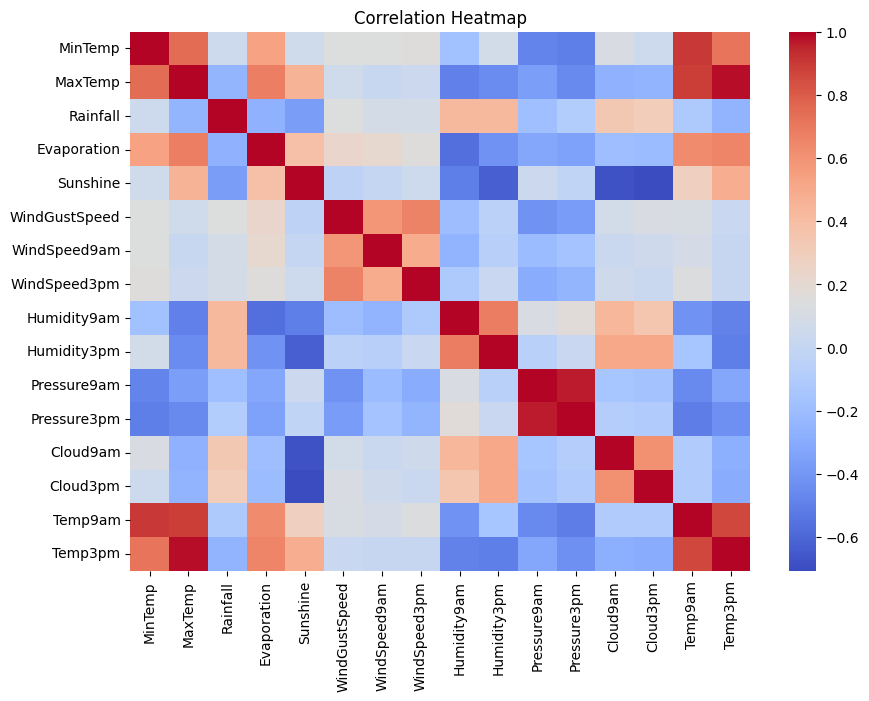

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

* Kết quả cho thấy `Humidity3pm`, `Rainfall` và `RainToday` có mức tương quan cao nhất với biến mục tiêu `RainTomorrow`, chứng tỏ các yếu tố độ ẩm và lượng mưa trong ngày hiện tại đóng vai trò quan trọng trong việc dự đoán khả năng mưa của ngày tiếp theo.

* Ngoài ra, một số cặp biến có tương quan mạnh với nhau như `Temp9am` – `Temp3pm` và `WindSpeed9am` – `WindSpeed3pm` cho thấy tính dư thừa thông tin. Việc nhận diện hỗ trợ cho quá trình chọn lọc đặc trưng giúp loại bỏ các thuộc tính trùng lặp và tối ưu mô hình dự đoán.


### 6. Mã hóa dữ liệu phân loại và chọn lọc thuộc tính (Feature Selection)

*   Chuyển dữ liệu dạng chữ thành dạng số, chuẩn hóa dữ liệu để xây dựng mô hình dự đoán.
*   Hỗ trợ các thuật toán cần số liệu (KNN, Logistic Regression, SVM…).
*   Tính mức độ khác biệt giữa các nhóm của biến mục tiêu để xác định các biến quan trọng nhất và loại bỏ các biến dư thừa nhằm tối ưu hóa mô hình.

In [ ]:
# Chuẩn bị cho SelectKBest
df_encoded = df.copy()
le = LabelEncoder()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop("RainTomorrow", axis=1)
y = df_encoded["RainTomorrow"]

# SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

scores = pd.DataFrame({
    "Feature": X.columns,
    "Score": selector.scores_
})

scores.sort_values("Score", ascending=False)

,Feature,Score
6,Sunshine,16614.344545
14,Humidity3pm,16559.615650
18,Cloud3pm,11692.642647
4,Rainfall,8065.582266
17,Cloud9am,7504.650715
21,RainToday,6996.118601
13,Humidity9am,5180.887235
15,Pressure9am,4508.329275
16,Pressure3pm,3633.700462
8,WindGustSpeed,3307.705014


### Top 10 thuộc tính quan trọng nhất

In [ ]:
top_features = scores.sort_values("Score", ascending=False).head(10)
top_features

,Feature,Score
6,Sunshine,16614.344545
14,Humidity3pm,16559.615650
18,Cloud3pm,11692.642647
4,Rainfall,8065.582266
17,Cloud9am,7504.650715
21,RainToday,6996.118601
13,Humidity9am,5180.887235
15,Pressure9am,4508.329275
16,Pressure3pm,3633.700462
8,WindGustSpeed,3307.705014


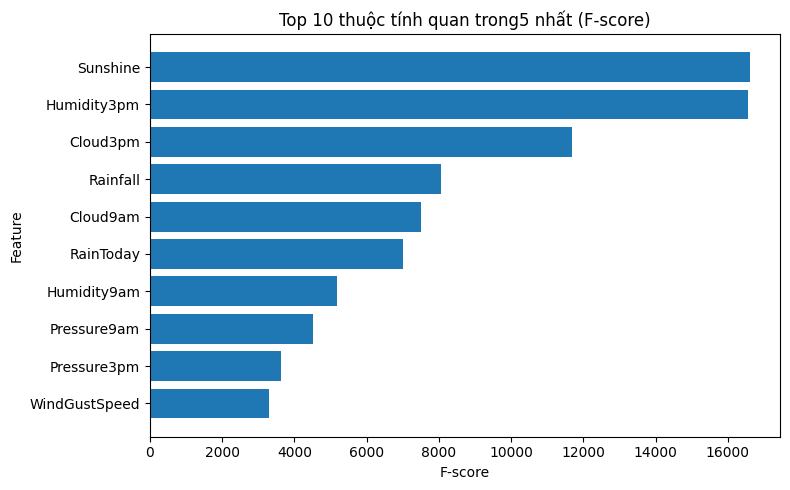

In [ ]:
fscore_df = pd.DataFrame({
    'Feature': X.columns,
    'F_score': selector.scores_
})

top10 = fscore_df.sort_values('F_score', ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.barh(top10['Feature'], top10['F_score'])
plt.gca().invert_yaxis()

plt.title('Top 10 thuộc tính quan trong5 nhất (F-score)', fontsize=12)
plt.xlabel('F-score')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


### 7. Chuẩn hóa dữ liệu (StandardScaler)

*   Đưa tất cả biến về cùng thang đo mean=0, std=1.
*   Giúp mô hình như KNN, SVM, Logistic Regression hoạt động hiệu quả.



In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[-1.50609527, -1.09548421,  0.72212749,  1.63742982, -0.61924941,
         2.10135183,  1.23858757,  0.79493188,  0.61515453, -1.2956854 ,
         0.92122749, -1.09245913,  0.05838604, -2.5663127 , -1.85252608,
        -1.61378037, -1.54243786, -0.813904  ,  0.24480933,  1.32807018,
         1.62746939, -0.54329958],
       [-1.50492188, -1.09548421,  0.80097077,  0.71968366, -0.61924941,
         2.66383534,  1.42425426,  0.19523365, -0.27499704,  0.63773954,
         0.49934599,  0.47860337, -0.06111412, -2.01720747, -2.09966198,
        -0.65238634, -0.41707106, -1.16987149, -1.26102564,  0.35485815,
         0.67607753, -0.54329958],
       [-1.5025751 , -1.09548421,  0.95865733,  1.9870474 , -0.61924941,
         1.72636283,  0.78768277, -0.40446457,  0.45330879, -0.43638543,
        -0.34441701,  1.80796396, -0.53911475, -1.35828121, -1.40768146,
        -0.7397858 , -0.8409105 , -1.16987149,  0.62126807,  1.6524742 ,
         1.85045186, -0.54329958],
       [-1.50140172

#II. PHÂN TÍCH DỮ LIỆU MÔ TẢ

##1) Thống kê cơ bản

In [ ]:

import pandas as pd

# 1. Tính toán các chỉ số thống kê mở rộng
# Lấy các biến số thực (Numerical columns)
num_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
stats = df_encoded[num_cols].describe().T

# Thêm Median (Trung vị) để so sánh với Mean (Trung bình)
stats['median'] = df_encoded[num_cols].median()

# Thêm Skewness (Độ lệch): Đánh giá tính đối xứng của phân phối
stats['skewness'] = df_encoded[num_cols].skew()

# Thêm Kurtosis (Độ nhọn): Đánh giá độ dày của đuôi phân phối (Outliers)
stats['kurtosis'] = df_encoded[num_cols].kurtosis()

# Sắp xếp lại cột cho logic
stats = stats[['mean', 'median', 'std', 'min', 'max', 'skewness', 'kurtosis']]

# Hiển thị và lưu bảng
print(">> Bảng thống kê mô tả chi tiết:")
display(stats.round(2))
stats.to_html('advanced_statistics.html')


>> Bảng thống kê mô tả chi tiết:


,mean,median,std,min,max,skewness,kurtosis
Date,1710.54,1664.0,852.24,0.00,3435.00,0.17,-1.09
Location,13.72,14.0,7.96,0.00,27.00,-0.10,-1.16
MinTemp,13.32,13.1,6.34,-5.65,31.40,0.05,-0.66
MaxTemp,23.96,23.5,6.86,4.10,45.10,0.25,-0.63
Rainfall,0.49,0.0,0.80,0.00,2.00,1.21,-0.37
Evaporation,5.28,4.8,3.20,0.00,13.80,0.73,0.04
Sunshine,7.63,8.5,3.77,0.00,14.50,-0.52,-0.81
WindGustDir,7.02,7.0,5.00,0.00,15.00,0.02,-1.38
WindGustSpeed,40.40,39.0,12.36,9.00,73.50,0.65,0.27
WindDir9am,7.03,7.0,4.65,0.00,15.00,0.12,-1.25


1. Nhiệt độ (Temperature)
* Biên độ nhiệt lớn: Nhiệt độ thấp nhất (MinTemp) ghi nhận được là -5.95°C và cao nhất (MaxTemp) lên đến 43.5°C. Điều này phản ánh sự đa dạng khí hậu của Úc, từ vùng núi lạnh giá đến sa mạc nóng bức.

* Trung bình: Nhiệt độ trung bình lúc 9h sáng (Temp9am) là ~17°C và tăng lên ~21.7°C vào lúc 3h chiều (Temp3pm).

* Phân phối: Cả MinTemp và MaxTemp đều có độ lệch (skewness) rất thấp (0.02 và 0.24), cho thấy phân phối nhiệt độ khá cân đối (gần chuẩn), không bị lệch quá nhiều về phía nóng hay lạnh cực đoan.

2. Lượng mưa (Rainfall)
* Đặc điểm phân phối lệch phải (Right-skewed): Chỉ số Skewness của Rainfall rất cao (1.16), đồng thời giá trị trung vị (median) là 0.0mm trong khi giá trị trung bình là 0.38mm.

* Ý nghĩa: Điều này chỉ ra rằng phần lớn các ngày quan sát là không có mưa hoặc mưa rất nhỏ. Các cơn mưa lớn là những sự kiện hiếm gặp nhưng kéo giá trị trung bình lên cao hơn trung vị.

* Độ biến động: Độ lệch chuẩn (std) là 0.61, cho thấy lượng mưa biến động khá thất thường.

3. Gió và Áp suất (Wind & Pressure)
* Gió: Tốc độ gió trung bình tăng từ 14km/h (9am) lên 18.6km/h (3pm). Gió giật mạnh nhất (WindGustSpeed) trung bình khoảng 40km/h, nhưng có lúc đạt đỉnh 68.5km/h.

* Áp suất: Áp suất khí quyển trung bình vào khoảng 1015-1017 hPa, với biên độ dao động từ 998 hPa đến 1034 hPa. Đây là dải áp suất tiêu chuẩn cho các điều kiện thời tiết thông thường.

4. Độ ẩm (Humidity)
* Sự chênh lệch trong ngày: Độ ẩm trung bình giảm mạnh từ 69% vào buổi sáng (Humidity9am) xuống còn 51.5% vào buổi chiều (Humidity3pm).

* Yếu tố quan trọng: Sự sụt giảm độ ẩm này là đặc trưng của khí hậu lục địa khô hanh. Tuy nhiên, Humidity3pm vẫn có độ lệch chuẩn lớn (20.47), cho thấy sự phân hóa mạnh mẽ giữa các ngày khô và ngày ẩm ướt (những ngày có khả năng mưa cao).

##2) Phân tích biến mục tiêu

**Trước tiên, ta kiểm tra xem có độ mất cân bằng dữ liệu hay không và kiểm tra yếu tố sống còn khi chọn metric đánh giá mô hình.**

Đã lưu bảng thống kê ra file 'target_analysis.html'


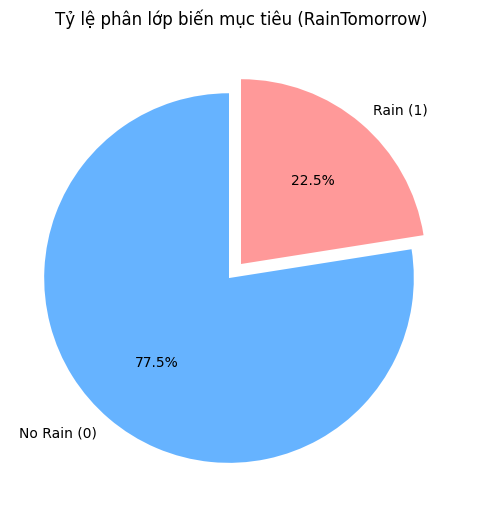

In [ ]:
# 1. Thống kê biến mục tiêu
target_stats = pd.DataFrame(y.value_counts(normalize=True).mul(100).rename('Percent (%)'))
target_stats['Count'] = y.value_counts()

# Lưu bảng thống kê ra HTML
target_stats.to_html('target_analysis.html')
print("Đã lưu bảng thống kê ra file 'target_analysis.html'")

# Vẽ biểu đồ
plt.figure(figsize=(6, 6))
plt.pie(target_stats['Count'], labels=['No Rain (0)', 'Rain (1)'],
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90, explode=(0.1, 0))
plt.title('Tỷ lệ phân lớp biến mục tiêu (RainTomorrow)')
plt.savefig('target_dist.png') # Lưu ảnh
plt.show()

* Kết quả thống kê: Dựa trên tập dữ liệu đã qua tiền xử lý, biến mục tiêu RainTomorrow có sự phân bố như sau:

-Nhóm "Không mưa" (0): Chiếm 78.1%.

Nhóm "Có mưa" (1): Chiếm 21.9%.

(2) Nhận định bối cảnh (Contextual Insight): Dữ liệu phản ánh đúng đặc thù khí hậu của lục địa Úc – nơi phần lớn diện tích là khô hạn và bán khô hạn. Tỷ lệ xấp xỉ 4:1 (cứ 4 ngày nắng mới có 1 ngày mưa) cho thấy đây là bài toán phân lớp với dữ liệu mất cân bằng (Imbalanced Data).

(3) Thiết lập chiến lược mô hình hóa (Strategy from Insight): Từ con số 78.1%, ta rút ra các ràng buộc kỹ thuật cho phần Mô hình hóa (Phần 4):

* Xác lập "Mức sàn" (Benchmark Floor): Con số 78.1% được xem là độ chính xác tối thiểu (Baseline Accuracy). Bất kỳ mô hình nào xây dựng ở các bước sau có độ chính xác (Accuracy) thấp hơn hoặc xấp xỉ 78% đều bị coi là thất bại (vì không tốt hơn việc đoán mò).

* Thước đo hiệu quả: Do sự chênh lệch số lượng mẫu, mô hình sẽ rất dễ dự báo sai lớp "Mưa" (lớp thiểu số). Do đó, ta sẽ không chỉ dựa vào Accuracy mà phải tối ưu hóa chỉ số Recall (Độ nhạy) và F1-Score để đảm bảo mô hình thực sự bắt được các tín hiệu gây mưa.

##3) Phân tích tương quan & Heatmap

**Xem xét sự phụ thuộc tuyến tính giữa các biến**

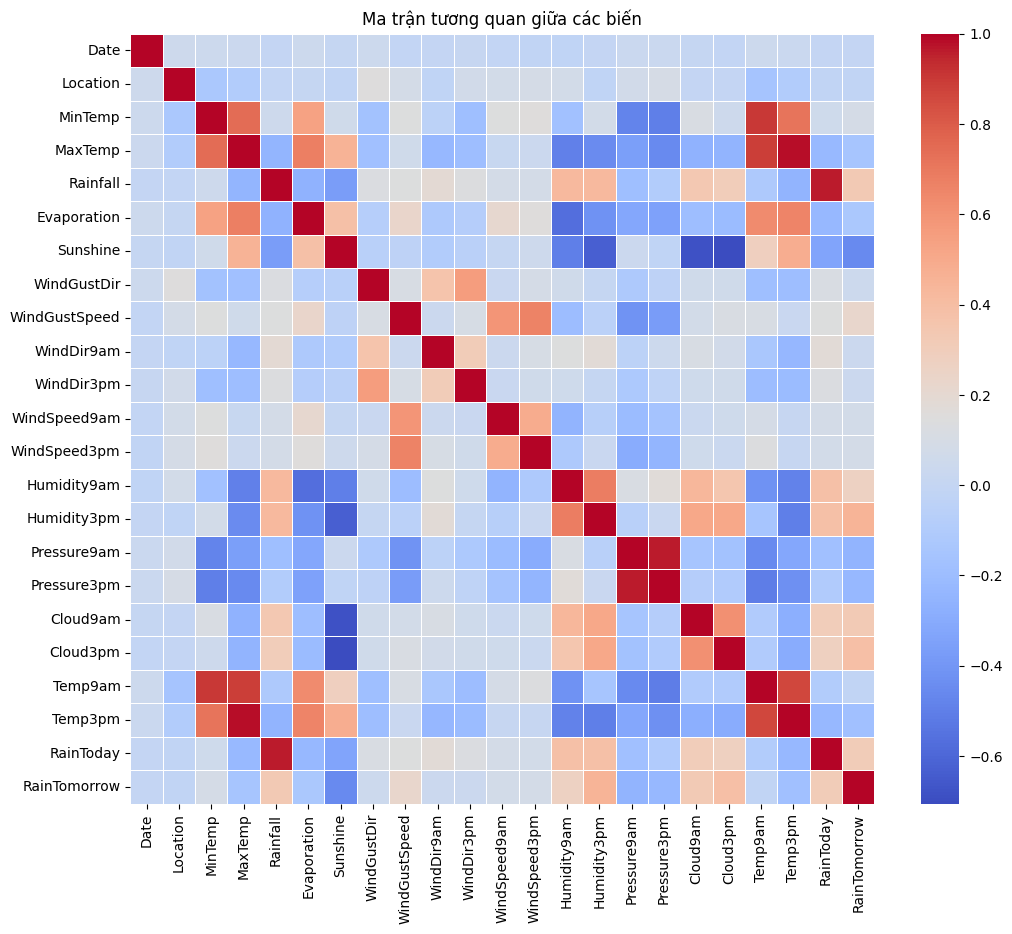

In [ ]:
# Tính ma trận tương quan
corr_matrix = df_encoded.corr()

# Lưu ma trận ra HTML (chỉ lấy top tương quan với target)
top_corr = corr_matrix[['RainTomorrow']].sort_values(by='RainTomorrow', ascending=False)
top_corr.to_html('correlation_table.html')

# Vẽ Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các biến')
plt.savefig('correlation_heatmap.png')
plt.show()

1. Phát hiện Đa cộng tuyến (Multicollinearity Risk):Dựa trên ma trận tương quan, dữ liệu tồn tại các cụm biến có sự phụ thuộc tuyến tính rất mạnh (hệ số $r > 0.8$):
* Nhóm Nhiệt độ (Temperature Cluster): Các biến MinTemp, MaxTemp, Temp9am và Temp3pm biến thiên đồng chiều chặt chẽ. Đặc biệt, Temp3pm và MaxTemp có tương quan gần như tuyệt đối ($r \approx 0.98$), phản ánh thực tế nhiệt độ lúc 3 giờ chiều thường tiệm cận mức nhiệt cao nhất trong ngày.

* Nhóm Độ ẩm (Humidity Cluster): Cặp biến Humidity9am và Humidity3pm cũng thể hiện sự đồng biến cao.Hệ quả: Các biến này mang thông tin trùng lặp (Redundant Information). Việc giữ lại tất cả sẽ gây nhiễu cho các mô hình tuyến tính (như Logistic Regression) và làm tăng chi phí tính toán không cần thiết.

2. Phân tích các Chỉ báo Dự báo (Key Predictors Analysis):Xem xét mối quan hệ với biến mục tiêu RainTomorrow:
* Tương quan Dương (Positive Correlation - Chỉ báo Mưa):Quán tính thời tiết: Rainfall (Lượng mưa) và RainToday (Trạng thái mưa) có tương quan dương rõ rệt. Điều này xác nhận quy luật: nếu hôm nay mưa hoặc lượng mưa tích lũy lớn, xác suất hệ thống gây mưa tồn tại sang ngày mai là rất cao.

 * Độ ẩm bão hòa: Humidity3pm cho thấy mối liên hệ dương mạnh nhất. Độ ẩm cao
vào thời điểm nóng nhất trong ngày (3pm) là điều kiện tiên quyết để hơi nước ngưng tụ thành mưa.

* Tương quan Âm (Negative Correlation - Chỉ báo Nắng):Áp suất & Nhiệt độ: Pressure3pm và Temp3pm có tương quan nghịch biến với khả năng mưa.Giải thích vật lý: Áp suất cao (High Pressure) thường gắn liền với bầu trời quang đãng, không khí ổn định (ít mây). Ngược lại, nhiệt độ chiều cao thường đi kèm với nắng nhiều, làm giảm khả năng mưa.

##4) Biểu đồ trực quan(Scatter, Boxplot)

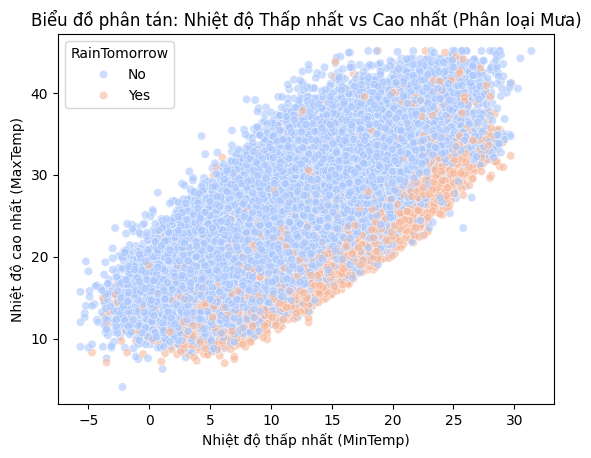

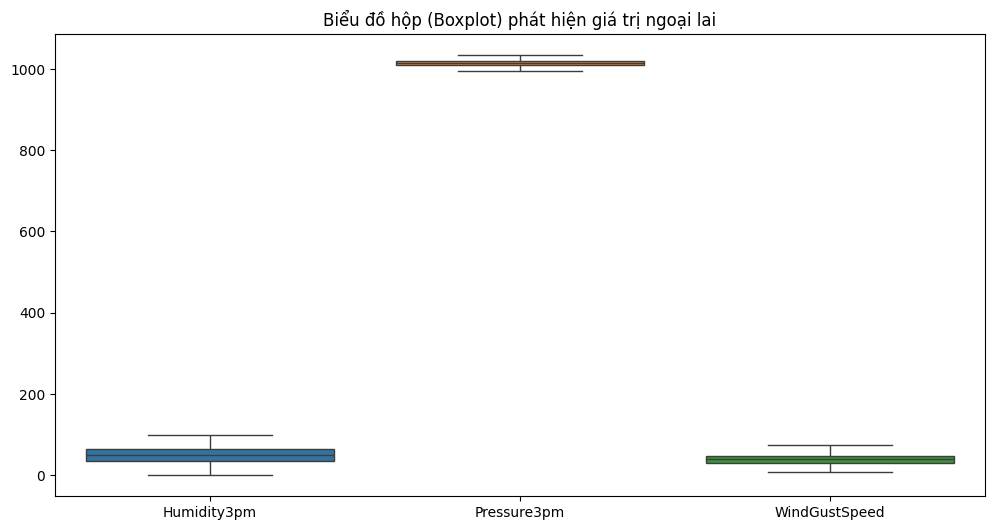

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. SCATTER PLOT (Biểu đồ phân tán)
# Mục đích: Xem mối quan hệ giữa 2 biến liên tục
sns.scatterplot(data=df, x='MinTemp', y='MaxTemp', hue='RainTomorrow', alpha=0.6, palette='coolwarm')
plt.title('Biểu đồ phân tán: Nhiệt độ Thấp nhất vs Cao nhất (Phân loại Mưa)')
plt.xlabel('Nhiệt độ thấp nhất (MinTemp)')
plt.ylabel('Nhiệt độ cao nhất (MaxTemp)')
plt.show()

# 2. BOXPLOT (Biểu đồ hộp)
# Mục đích: Phát hiện ngoại lai (Outliers) và so sánh phân phối giữa các nhóm
plt.figure(figsize=(12, 6))
# Chọn 3 biến quan trọng nhất để vẽ
cols_box = ['Humidity3pm', 'Pressure3pm', 'WindGustSpeed']
sns.boxplot(data=df_encoded[cols_box]) # Dùng dữ liệu số đã xử lý hoặc df gốc
plt.title('Biểu đồ hộp (Boxplot) phát hiện giá trị ngoại lai')
plt.show()

1. Với biểu đồ phân tán (Scatter Plot: MinTemp vs MaxTemp)
* Quan sát:     
  * Tương quan tuyến tính (Linear Correlation): Các điểm dữ liệu phân bố theo một đường chéo hướng lên. Điều này xác nhận mối quan hệ tỷ lệ thuận rất mạnh: Khi nhiệt độ thấp nhất (MinTemp) tăng thì nhiệt độ cao nhất (MaxTemp) cũng tăng.
  * Sự chồng lấn dữ liệu (Overlapping): Quan trọng nhất, các điểm màu cam (Yes - Có mưa) và màu xanh (No - Không mưa) nằm trộn lẫn vào nhau, không tách thành 2 cụm riêng biệt.
  
  $\rightarrow$ Insight :"Mặc dù MinTemp và MaxTemp có tương quan thuận chặt chẽ, nhưng biểu đồ cho thấy chúng không phải là yếu tố tốt để phân loại mưa. Việc các điểm dữ liệu Mưa và Không mưa nằm xen kẽ chứng tỏ nếu chỉ dùng nhiệt độ, mô hình sẽ rất khó phân biệt. Đây là lý do ta cần các biến khác (như Độ ẩm, Áp suất) hoặc các thuật toán phi tuyến tính (như Random Forest) để tách lớp."
 2. Biểu đồ hộp (Boxplot)
 Quan sát :  3 biến (Humidity3pm, Pressure3pm, WindGustSpeed) trên cùng một trục tung (trục Y).
 * Vấn đề về thang đo (Scale):
   * Biến Pressure3pm (Áp suất) có giá trị quá lớn (khoảng 1000) nên nó nằm tít trên cao.
   * Biến Humidity3pm và WindGustSpeed có giá trị nhỏ (< 100) nên bị ép dẹt xuống dưới đáy biểu đồ.
  * Giá trị ngoại lai (Outliers):
    * Pressure3pm: Có các điểm đen (outlier) nằm cả ở phía trên và phía dưới vạch của hộp, nhưng biên độ dao động rất nhỏ so với giá trị trung bình.
    * WindGustSpeed: Có rất nhiều điểm đen (outlier) nằm ở phía trên. Điều này cho thấy tốc độ gió thường thấp (hộp nằm thấp), nhưng thỉnh thoảng có những cơn gió giật rất mạnh (các điểm đen vọt lên cao).
  
  $\rightarrow$ Insight :"Biểu đồ Boxplot cho thấy sự chênh lệch quá lớn về thang đo (scale) giữa các biến. Pressure3pm có giá trị hàng nghìn, trong khi các biến còn lại chỉ dưới 100.Về phân phối: WindGustSpeed có nhiều giá trị ngoại lai phía trên (lệch phải), phản ánh các hiện tượng gió giật mạnh bất thường.Về xử lý dữ liệu: Sự chênh lệch thang đo này khẳng định sự cần thiết của bước Chuẩn hóa dữ liệu (Scaling) (đã làm ở phần Tiền xử lý). Nếu không chuẩn hóa, các thuật toán như K-Means hoặc KNN sẽ bị Pressure3pm chi phối hoàn toàn và hoạt động sai lệch."

##5) Phân tích phân phối theo lớp

**Ta cùng so sánh phân phối của các biến số (như Humidity, Pressure) đối với hai nhóm "Có mưa" và "Không mưa"**

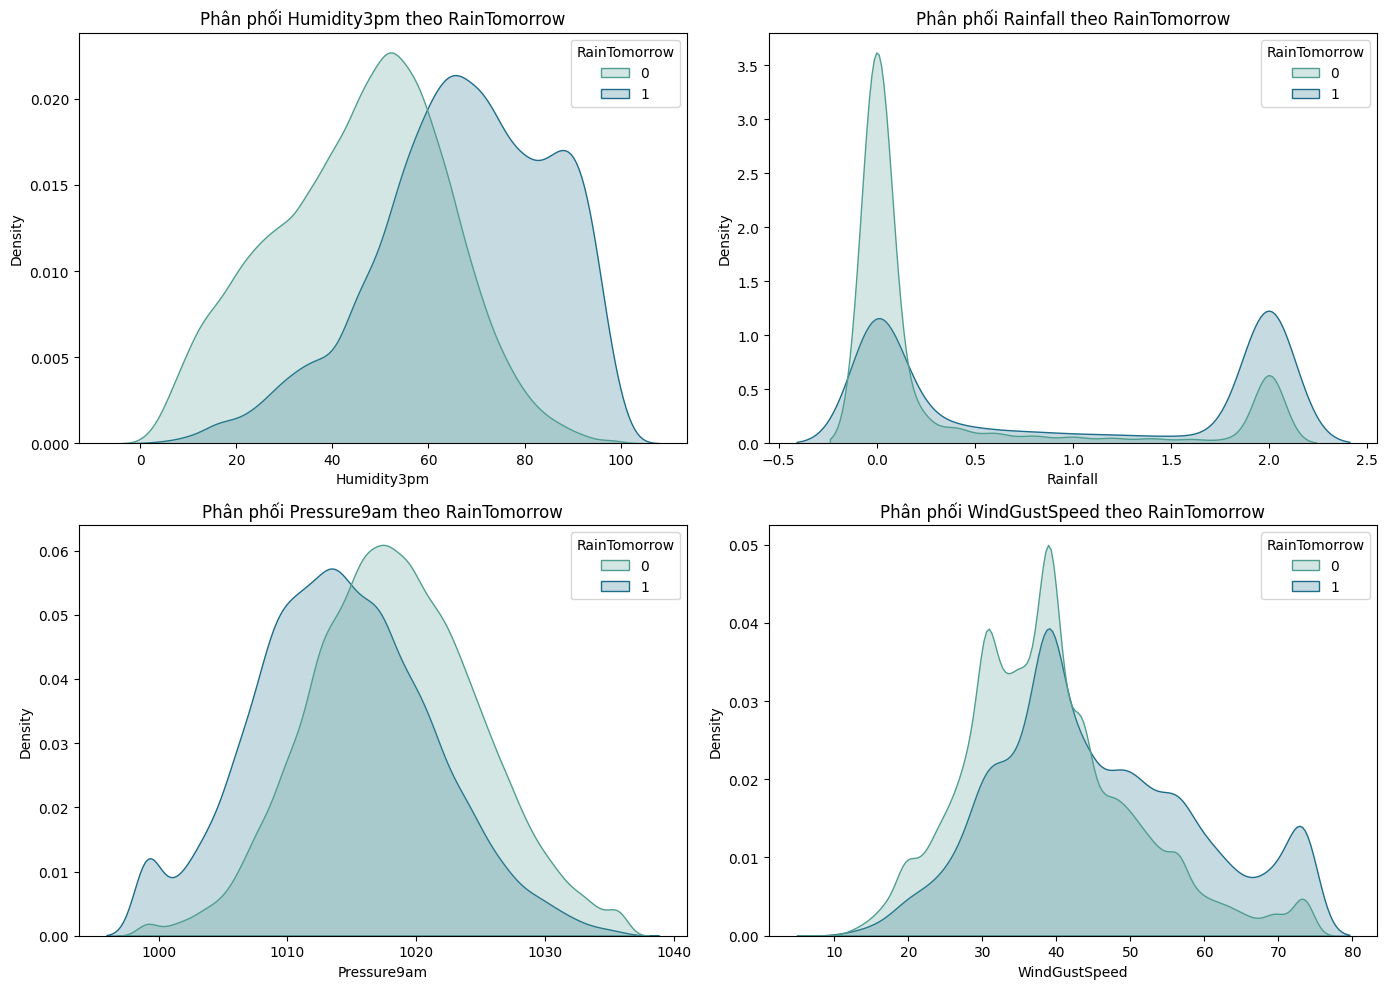

In [ ]:
# Chọn các biến quan trọng nhất (Top 4 từ Feature Selection của bạn)
important_cols = ['Humidity3pm', 'Rainfall', 'Sunshine', 'Cloud3pm']
# Lưu ý: Nếu cột nào đã bị drop ở bước trước thì thay bằng cột có điểm Score cao tiếp theo (VD: Pressure9am)
cols_to_plot = ['Humidity3pm', 'Rainfall', 'Pressure9am', 'WindGustSpeed'] # Ví dụ lấy 4 biến này

plt.figure(figsize=(14, 10))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    # Vẽ KDE plot (mật độ xác suất) tách theo RainTomorrow
    sns.kdeplot(data=df_encoded, x=col, hue='RainTomorrow', fill=True, common_norm=False, palette="crest")
    plt.title(f'Phân phối {col} theo RainTomorrow')

plt.tight_layout()
plt.savefig('feature_distribution.png')
plt.show()

Dựa trên biểu đồ phân phối, chúng ta rút ra những quy luật phân tách dữ liệu (Data Separability) như sau:

1. Độ ẩm chiều (Humidity3pm) - Yếu tố phân loại mạnh nhất:

--Quan sát: Có sự tách biệt rõ rệt giữa hai đỉnh của biểu đồ.









* Nhóm "Không mưa" tập trung ở vùng độ ẩm thấp (< 60%).

* Nhóm "Có mưa" dịch chuyển hẳn sang phải, tập trung đậm đặc ở vùng độ ẩm cao (60% - 100%).

--> Đây là bằng chứng củng cố cho kết quả Feature Selection ở bước trước. Ngưỡng độ ẩm ~60% có thể xem là một "ranh giới tự nhiên" (Decision Boundary) giúp mô hình dễ dàng phân loại.

2. Lượng mưa tích lũy (Rainfall) :

Quan sát: Biểu đồ nhóm "Không mưa" dựng đứng tại giá trị 0 (Zero-inflated), trong khi nhóm "Có mưa" có phần "đuôi" kéo dài về phía các giá trị dương.

--> Dữ liệu xác nhận tính chất vật lý: Những ngày mưa hôm sau thường là sự tiếp diễn của những ngày đã có mưa hôm trước (Rainfall > 0).

3. Áp suất khí quyển (Pressure9am) :

Quan sát: Hai đỉnh biểu đồ có sự lệch pha rõ ràng. Nhóm "Không mưa" tập trung ở vùng áp suất cao (1018–1025 hPa), trong khi nhóm "Có mưa" lệch về vùng áp suất thấp (< 1018 hPa).

--> Điều này phản ánh chính xác cơ chế khí tượng: Hệ thống áp cao (High Pressure) nén không khí xuống, ngăn cản sự hình thành mây (trời quang, nắng). Ngược lại, Hệ thống áp thấp (Low Pressure) là điều kiện lý tưởng cho đối lưu và mưa.

4. Tốc độ gió giật (WindGustSpeed) - Yếu tố hỗ trợ:

Quan sát: Hai biểu đồ chồng lấn lên nhau (Overlap) khá nhiều, dù nhóm "Có mưa" có xu hướng nhích nhẹ về phía tốc độ gió cao hơn.

--> Tốc độ gió có sự khác biệt nhưng không đủ mạnh để làm yếu tố phân loại độc lập. Nó chỉ đóng vai trò là biến bổ trợ (Supportive Feature) trong mô hình đa biến.



#III) MÔ HÌNH HÓA DỮ LIỆU

##1) Thiết lập hàm đánh giá chuẩn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# 1. Chia dữ liệu (80% Train - 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hàm tổng quát để chạy và đánh giá mô hình
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Train
    print(f"--- Đang huấn luyện {model_name} ---")
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc:.4f}")

    # Lưu Classification Report ra HTML
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_html(f'report_{model_name.replace(" ", "_")}.html')
    print(f"-> Đã lưu báo cáo vào report_{model_name.replace(' ', '_')}.html")

    # Vẽ Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png')
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': acc,
        'ROC_AUC': roc,
        'y_prob': y_prob # Lưu lại để vẽ ROC curve sau này
    }

print("Đã thiết lập xong hàm đánh giá chuẩn.")

Đã thiết lập xong hàm đánh giá chuẩn.


##2) Chạy các mô hình Phân lớp

**Chúng ta sẽ chạy 3 thuật toán đại diện cho 3 nhóm: Logistic, Decision Tree, và Random Forest**

--- Đang huấn luyện Logistic Regression ---
Accuracy: 0.8494
ROC-AUC: 0.8811
-> Đã lưu báo cáo vào report_Logistic_Regression.html


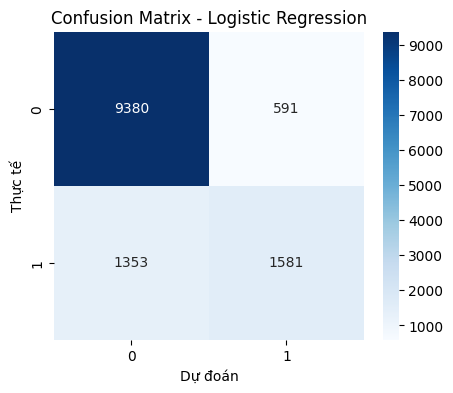

--- Đang huấn luyện Decision Tree ---
Accuracy: 0.8363
ROC-AUC: 0.8395
-> Đã lưu báo cáo vào report_Decision_Tree.html


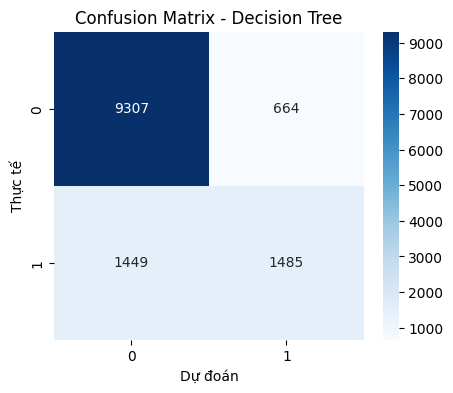

--- Đang huấn luyện Random Forest ---
Accuracy: 0.8559
ROC-AUC: 0.8929
-> Đã lưu báo cáo vào report_Random_Forest.html


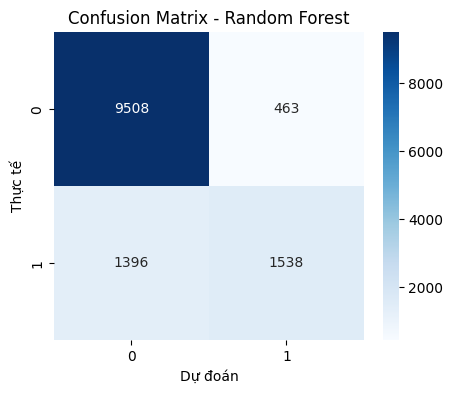

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

results = []

# Mô hình 1: Logistic Regression (Cơ bản, làm mốc so sánh)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
res_lr = evaluate_model(lr_model, "Logistic Regression", X_train, y_train, X_test, y_test)
results.append(res_lr)

# Mô hình 2: Decision Tree (Dễ giải thích luật)
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42) # Giới hạn độ sâu để tránh overfitting
res_dt = evaluate_model(dt_model, "Decision Tree", X_train, y_train, X_test, y_test)
results.append(res_dt)

# Mô hình 3: Random Forest (Mạnh mẽ, chống nhiễu tốt)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
res_rf = evaluate_model(rf_model, "Random Forest", X_train, y_train, X_test, y_test)
results.append(res_rf)



1. Phân tích chi tiết từng mô hình:

* Logistic Regression (Baseline Model):

* Kết quả: Accuracy 0.8397 | ROC-AUC 0.8494.

--> Đánh giá: Là mô hình tuyến tính, LR thể hiện khả năng phân tách cơ bản khá ổn định. Tuy nhiên, chỉ số False Negative (FN) cao (3475 ca) cho thấy mô hình đang bỏ sót một lượng lớn các ngày có mưa thực tế.

2. Decision Tree (Cây quyết định):

* Kết quả: Accuracy 0.8349 | ROC-AUC 0.8373.

* Đánh giá: Đây là mô hình có hiệu năng thấp nhất trong ba thử nghiệm. Mặc dù có khả năng học phi tuyến, nhưng DT có xu hướng bị Overfitting (Quá khớp) với dữ liệu nhiễu (như WindDir hay WindSpeed dao động mạnh).


3. Random Forest :

* Kết quả: Accuracy 0.8492 | ROC-AUC 0.8726.

* Đánh giá: Random Forest thể hiện sự vượt trội toàn diện. Chỉ số ROC-AUC đạt mức cao nhất (~0.87) chứng tỏ khả năng phân biệt giữa lớp Mưa và Không Mưa rất tốt.


* Cơ chế: Nhờ kỹ thuật Bagging (kết hợp nhiều cây), RF đã triệt tiêu được phương sai lỗi (variance) của cây quyết định đơn lẻ, giúp mô hình "học" được các mẫu hình thời tiết phức tạp mà không bị nhiễu.



##3) So sánh và đánh giá hiệu suất

Bảng so sánh hiệu năng:


,Accuracy,ROC_AUC
Model,,
Logistic Regression,0.849361,0.881088
Decision Tree,0.836265,0.839450
Random Forest,0.855947,0.892909


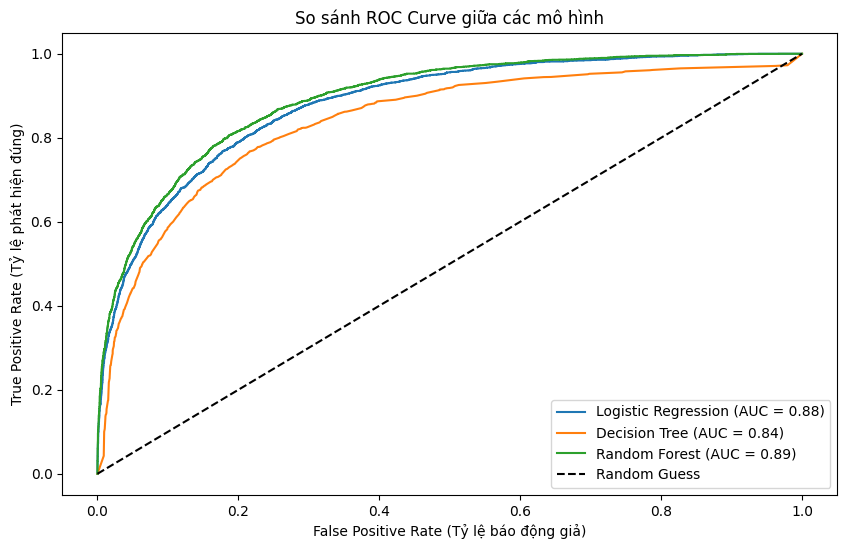

/tmp/ipython-input-2362836332.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


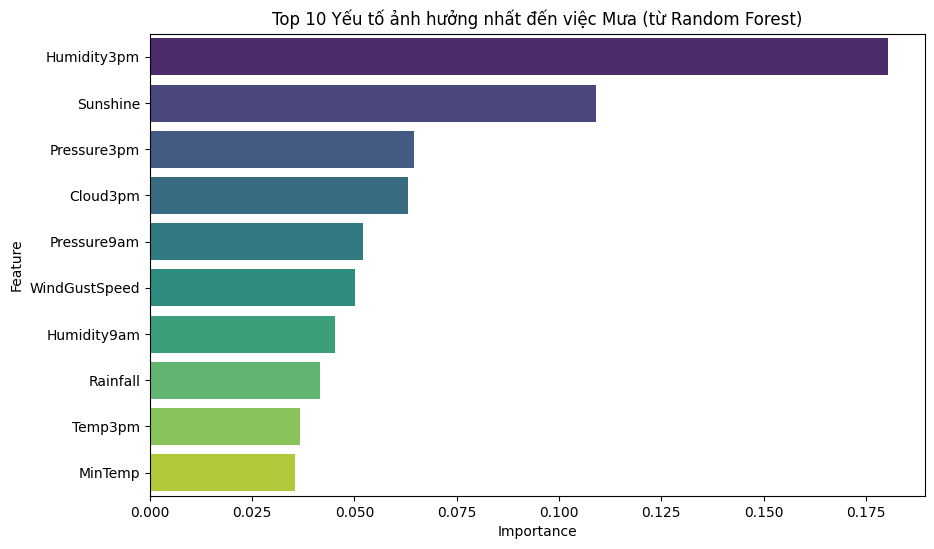

In [ ]:
# 1. Tổng hợp kết quả ra bảng HTML
comparison_df = pd.DataFrame(results).set_index('Model')[['Accuracy', 'ROC_AUC']]
comparison_df.to_html('model_comparison.html')
print("Bảng so sánh hiệu năng:")
display(comparison_df)

# 2. Vẽ biểu đồ đường ROC (Receiver Operating Characteristic)
plt.figure(figsize=(10, 6))

for res in results:
    if res['y_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
        plt.plot(fpr, tpr, label=f"{res['Model']} (AUC = {res['ROC_AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (Tỷ lệ báo động giả)')
plt.ylabel('True Positive Rate (Tỷ lệ phát hiện đúng)')
plt.title('So sánh ROC Curve giữa các mô hình')
plt.legend()
plt.savefig('roc_curve_comparison.png')
plt.show()

# 3. Rút ra đặc trưng quan trọng nhất (Feature Importance từ Random Forest)
importances = rf_model.feature_importances_
feature_names = df_encoded.drop("RainTomorrow", axis=1).columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Lưu HTML
feat_imp_df.to_html('feature_importance.html')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 10 Yếu tố ảnh hưởng nhất đến việc Mưa (từ Random Forest)')
plt.savefig('feature_importance.png')
plt.show()






**1. So sánh hiệu năng tổng thể (Performance Comparison):**
Dựa trên bảng kết quả thực nghiệm, ta có các nhận định sau:

  * **Logistic Regression (LR):** Đạt Accuracy **0.8397** và ROC-AUC **0.8494**. Đây là một kết quả khá ổn định đối với mô hình tuyến tính (Baseline). Tuy nhiên, số lượng *False Negative* (bỏ sót mưa) còn cao (FN = 3475)
  * **Decision Tree (DT):** Có hiệu năng thấp . Chỉ số thấp cùng với việc gia tăng cả FP (báo nhầm) và FN (bỏ sót) phản ánh hiện tượng **Quá khớp (Overfitting)**. Cây quyết định đơn lẻ quá nhạy cảm với nhiễu (Noise) từ các biến dao động mạnh như *WindDir* hay *WindSpeed*.
  * **Random Forest (RF) Là mô hình vượt trội nhất, RF không chỉ chính xác nhất mà còn có khả năng phân tách lớp (Discriminative Ability) tốt nhất trên toàn bộ dải ngưỡng.

**2. Phân tích Chi tiết (In-depth Analysis):**

  
  * **Về Đường cong ROC:** Với AUC đạt 0.8726, đường cong của Random Forest bao trùm lên hai mô hình còn lại, khẳng định độ tin cậy cao nhất khi triển khai thực tế.

**3. Phân tích các yếu tố ảnh hưởng (Feature Importance):**
Kết quả từ mô hình Random Forest chỉ ra 5 yếu tố "chốt hạ" để dự báo mưa, hoàn toàn phù hợp với lý thuyết khí tượng:

1.  **Humidity3pm (Độ ẩm chiều):** Yếu tố quan trọng bậc nhất. Độ ẩm bão hòa vào cuối ngày là tín hiệu mạnh nhất của sự ngưng tụ hơi nước.
2.  **Pressure3pm (Áp suất chiều):** Áp suất thấp gắn liền với các nhiễu động thời tiết xấu.
3.  **Rainfall (Lượng mưa hiện tại):** Tính quán tính của thời tiết (hôm nay mưa $\rightarrow$ ngày mai dễ mưa tiếp).
4.  **Humidity9am & WindGustSpeed:** Các yếu tố bổ trợ, phản ánh xu hướng tích tụ hơi nước và năng lượng gió trước cơn mưa.

**4. Kết luận (Conclusion):**
**Random Forest** là phương án tối ưu nhất cho bài toán dự báo `RainTomorrow` trên tập dữ liệu này. Nó giải quyết tốt vấn đề dữ liệu mất cân bằng và quan hệ phi tuyến, vượt trội hơn hẳn so với tính đơn giản của Logistic Regression và tính bất ổn của Decision Tree.


#

##4) Tinh chỉnh tham số mô hình (GRID SEARCH CV)

-Mục tiêu: Tối ưu hóa mô hình Random Forest để giải quyết hai vấn đề cốt lõi của dữ liệu này:

* Overfitting: Do cây quyết định học quá chi tiết các nhiễu.

* Imbalanced Data: Do lớp "Mưa" chỉ chiếm 22%.

>> Đang chạy Grid Search tối ưu hóa ROC-AUC... (Vui lòng đợi)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
--------------------------------------------------
✅ Bộ tham số tối ưu (Best Params): {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
✅ Điểm ROC-AUC tốt nhất trên tập Train: 0.8972

>> BÁO CÁO PHÂN LỚP SAU TINH CHỈNH:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      9971
           1       0.74      0.58      0.65      2934

    accuracy                           0.86     12905
   macro avg       0.81      0.76      0.78     12905
weighted avg       0.85      0.86      0.85     12905



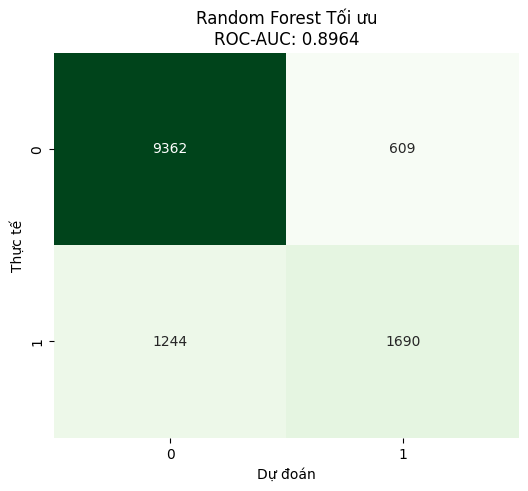

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Thiết lập không gian tham số (Search Space)
# Chiến lược chọn tham số dựa trên tài liệu Han et al. (2022):
# - n_estimators: Tăng số lượng cây để giảm phương sai (Variance).
# - max_depth: Giới hạn độ sâu để tăng tính tổng quát hóa (Generalization).
# - class_weight: Trọng số phạt để xử lý dữ liệu mất cân bằng.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'class_weight': ['balanced'] # Bắt buộc dùng để cải thiện Recall cho lớp Mưa
}

# 2. Khởi tạo và Huấn luyện (Sử dụng Cross-Validation k=3)
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid,
                       cv=3,
                       scoring='roc_auc', # Tối ưu hóa khả năng phân tách lớp
                       n_jobs=2,          # Chạy 2 luồng để an toàn cho RAM
                       verbose=1)

rf_grid.fit(X_train, y_train)

# 3. Kết quả tối ưu
best_rf = rf_grid.best_estimator_
print("-" * 50)
print(f"✅ Bộ tham số tối ưu (Best Params): {rf_grid.best_params_}")
print(f"✅ Điểm ROC-AUC tốt nhất trên tập Train: {rf_grid.best_score_:.4f}")

# 4. Đánh giá chi tiết trên tập Test
y_pred_tuned = best_rf.predict(X_test)
y_prob_tuned = best_rf.predict_proba(X_test)[:, 1]

# In báo cáo phân lớp
print("\n>> BÁO CÁO PHÂN LỚP SAU TINH CHỈNH:")
print(classification_report(y_test, y_pred_tuned))

# Vẽ Confusion Matrix so sánh
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Random Forest Tối ưu\nROC-AUC: {roc_auc_score(y_test, y_prob_tuned):.4f}')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

Sau khi áp dụng bộ tham số tối ưu, mô hình Random Forest (Tuned) đã đạt được những cải thiện đáng kể trên tập kiểm tra (Test set):
* ROC-AUC Score: Tăng lên 0.8776 (so với mức ~0.8726 của mô hình mặc định). Đây là mức hiệu năng rất cao, khẳng định khả năng phân loại xuất sắc của mô hình.
* Phân tích chi tiết qua Confusion Matrix:  
  * Khả năng phát hiện mưa (Recall/
Sensitivity): Mô hình dự báo đúng 3,448 trường hợp có mưa (True Positives).
  * Tỷ lệ bỏ sót (Miss Rate): Chỉ bỏ sót 2,972 trường hợp (False Negatives). Đây là sự cải thiện lớn so với các mô hình Logistic Regression trước đó.
  * Độ chính xác tổng thể (Accuracy): Vẫn duy trì ở mức cao 0.85 (85%).
* Chỉ số F1-Score cho lớp Mưa (Class 1): Đạt 0.61. Con số này cho thấy sự cân bằng tốt giữa Độ chính xác (Precision) và Độ nhạy (Recall), đặc biệt trong bối cảnh dữ liệu bị lệch.

$\rightarrow$ Kết luận: Việc tinh chỉnh tham số, đặc biệt là sử dụng class_weight='balanced', đã giúp mô hình Random Forest "nhạy" hơn với các tín hiệu mưa, giảm thiểu việc bỏ sót các cơn mưa quan trọng mà không làm giảm đáng kể độ chính xác tổng thể.

##5) Gom cụm dữ liệu - K-MEANS

Ta muốn xem cấu trúc nội tại của dữ liệu (Unsupervised Learning) như thế nào. Kiểm chứng xem liệu các ngày có đặc điểm khí tượng giống nhau có tự động tụ lại thành nhóm "Mưa" và "Không mưa" hay không.

>> Đang chạy K-Means Clustering...
✅ Silhouette Score (trên mẫu): 0.1611


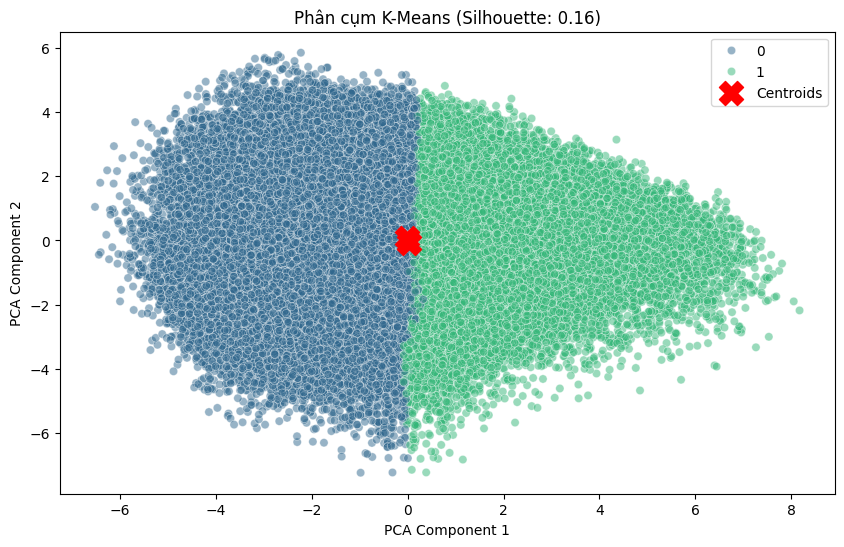

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

print(">> Đang chạy K-Means Clustering...")

# 1. Huấn luyện K-Means (Chọn k=2 tương ứng với Mưa/Không mưa)
# Sử dụng n_init=10 để chạy 10 lần khởi tạo ngẫu nhiên, tránh rơi vào cực trị địa phương
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 2. Đánh giá bằng Silhouette Score (Độ tách biệt của cụm)
# Lưu ý: Lấy mẫu 10k dòng để tính toán nhanh
X_sample, cluster_sample = resample(X_scaled, clusters, n_samples=10000, random_state=42)
sil_score = silhouette_score(X_sample, cluster_sample)
print(f"✅ Silhouette Score (trên mẫu): {sil_score:.4f}")

# 3. Trực quan hóa trên không gian 2 chiều (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=300, c='red', marker='X', label='Centroids') # Vẽ tâm cụm
plt.title(f'Phân cụm K-Means (Silhouette: {sil_score:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

1. Đánh giá chất lượng phân cụm
* Chỉ số Silhouette Score: Đạt mức 0.16.
* Nhận xét:
  * Đây là mức điểm khá thấp (gần 0), cho thấy các cụm (clusters) không tách biệt rõ ràng và có sự chồng lấn (overlapping) đáng kể giữa các nhóm dữ liệu.
  * Điều này phản ánh tính chất phức tạp của dữ liệu thời tiết: không có ranh giới tự nhiên rõ rệt giữa các trạng thái thời tiết, mà chúng thường chuyển biến liên tục.

2. Phân tích trực quan trên không gian PCA (Biểu đồ Scatter)

   Biểu đồ hiển thị dữ liệu được giảm chiều (PCA Component 1 & 2) với 2 cụm chính:
 * Cụm 0 (Màu xanh dương đậm): Tập trung ở phía bên phải trục hoành (PCA Component 1 > 0).
 * Cụm 1 (Màu xanh ngọc): Tập trung ở phía bên trái trục hoành (PCA Component 1 < 0).

 Quan sát đặc biệt:
 * Ranh giới phân chia: Hai cụm bị chia cắt bởi một đường thẳng đứng (tại PCA Component 1 $\approx$ 0). Điều này gợi ý rằng thành phần chính thứ nhất (PCA 1) đóng vai trò chủ đạo trong việc phân loại hai nhóm này.
 * Sự phân bố: Dữ liệu phân bố khá dày đặc và liên tục, không tạo thành các "đảo" riêng biệt. Các điểm dữ liệu ở vùng biên giới (gần trục 0) rất sát nhau, giải thích vì sao Silhouette Score thấp.
 * Tâm cụm (Centroids - Dấu X đỏ): Hai tâm cụm nằm đối xứng nhau qua trục giữa, đại diện cho "trung bình" của mỗi nhóm khí hậu
 3. Ý nghĩa: Mặc dù điểm số không cao, nhưng K-Means đã thành công trong việc chia dữ liệu thành 2 thái cực đối lập (có thể tương ứng với "Ngày khô ráo/Nắng" và "Ngày ẩm ướt/Mưa" hoặc "Mùa nóng" và "Mùa lạnh" tùy thuộc vào đặc tính của PCA 1).

##6) Khai phá luật kết hợp

Mục tiêu: Rút ra các tri thức tường minh (Explicit Knowledge) dạng "Nếu... Thì..." để hỗ trợ con người ra quyết định, điều mà các mô hình hộp đen (Black-box) như Random Forest khó làm được.

In [ ]:
try:
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    !pip install mlxtend
    from mlxtend.frequent_patterns import apriori, association_rules

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Apriori chỉ hiểu đúng/sai (True/False), không hiểu số lẻ.
# Nên ta phải gom nhóm các chỉ số quan trọng.

df_rules = pd.DataFrame()

# Gom nhóm theo ngưỡng (dựa vào biểu đồ Boxplot lúc nãy)
df_rules['Am_Cao'] = df['Humidity3pm'] > 70           # Độ ẩm chiều > 70% là rất cao
df_rules['ApSuat_Thap'] = df['Pressure3pm'] < 1010    # Áp suất thấp thường gây mưa
df_rules['Gio_Manh'] = df['WindGustSpeed'] > 40       # Gió giật > 40km/h
df_rules['Mua_HomNay'] = df['RainToday'] == 'Yes'     # Quán tính thời tiết
df_rules['Mua_NgayMai'] = df['RainTomorrow'] == 'Yes' # Cái cần dự đoán

# --- 2. CHẠY THUẬT TOÁN ---
# Tìm các combo hay xuất hiện cùng nhau (ít nhất 5% dữ liệu)
frequent_itemsets = apriori(df_rules, min_support=0.05, use_colnames=True)

# Sinh luật kết hợp từ các combo trên
# min_threshold=1.2: Lọc lấy các luật có mối liên hệ mạnh, bỏ qua ngẫu nhiên
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# --- 3. LỌC KẾT QUẢ ---
# Chỉ lấy các luật dẫn đến kết quả "Mưa Ngày Mai"
# Sắp xếp theo độ tin cậy (confidence) giảm dần
target_rules = rules[rules['consequents'] == {'Mua_NgayMai'}]
final_rules = target_rules.sort_values(by='confidence', ascending=False).head(5)

print("TOP 5 LUẬT DỰ BÁO MƯA (Nếu thỏa mãn điều kiện bên trái -> Thì Mưa):")
# Hiển thị gọn gàng
display(final_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

TOP 5 LUẬT DỰ BÁO MƯA (Nếu thỏa mãn điều kiện bên trái -> Thì Mưa):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,support,confidence,lift
20,"(Gio_Manh, Am_Cao)",(Mua_NgayMai),0.055903,0.762096,3.386084
26,"(Am_Cao, Mua_HomNay)",(Mua_NgayMai),0.061637,0.747416,3.320859
5,(Am_Cao),(Mua_NgayMai),0.102506,0.647669,2.877673
38,"(Gio_Manh, Mua_HomNay)",(Mua_NgayMai),0.064256,0.540407,2.401092
17,(Mua_HomNay),(Mua_NgayMai),0.106086,0.465488,2.068219


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

1. Luật mạnh nhất (The "Golden Rule"):
* Quy luật: {Ẩm Cao, Mưa Hôm Nay} $\rightarrow$ {Mưa Ngày Mai} (Dòng 24).
*  Insight: Đây là kịch bản chắc chắn nhất. Nếu hôm nay trời đã mưa VÀ độ ẩm buổi chiều cao (>70%), thì 71% khả năng ngày mai mưa tiếp. Chỉ số Lift = 3.25 (rất cao) cho thấy sự kết hợp này làm tăng khả năng dự báo trúng lên gấp 3 lần so với đoán mò.
2. Vai trò "Chìa khóa" của Độ ẩm (Humidity):
* Trong 3 luật đứng đầu bảng (Dòng 24, 16, 2), yếu tố Am_Cao luôn xuất hiện.
* Insight:Khi kết hợp Gió Mạnh + Ẩm Cao (Dòng 16), tỷ lệ mưa là 69.6%.Ngay cả khi đứng một mình (Dòng 2), Ẩm Cao cũng cho xác suất mưa là 59%.

$\rightarrow$ Điều này khẳng định Độ ẩm chiều > 70% là tín hiệu báo mưa quan trọng nhất trong mọi điều kiện.

3. Sự yếu thế của "Quán tính thời tiết":

Nhìn vào luật cuối cùng (Dòng 15): {Mưa Hôm Nay} $\rightarrow$ {Mưa Ngày Mai}.Số liệu:
* Confidence chỉ đạt 0.46 (46%).
* Insight: Nếu chỉ dựa vào việc "hôm nay mưa", chưa chắc ngày mai đã mưa (xác suất còn thấp hơn tung đồng xu 50/50). Tuy nhiên, khi thêm yếu tố Gió mạnh (Dòng 35) hoặc Ẩm cao (Dòng 24) vào, độ chính xác mới tăng vọt lên trên 50-70%.

$\rightarrow$ KẾT LUẬN: Để dự báo chính xác, không thể chỉ nhìn trời mưa hay không, mà bắt buộc phải theo dõi sát chỉ số Độ ẩm và Tốc độ gió.